In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from metpy.units import units

from Map import Map

In [2]:
'''
Define Model Parameters
'''
LOCATION = 'tropical_atlantic'
MODEL_DATE = '20230610'
MODEL_CYCLE = '00z'
VALID_TIME = '2023-06-19T1800'

# Define area to plot
BOTTOM_LAT = 5
TOP_LAT = 40
LEFT_LON = -100
RIGHT_LON = -60

## Get Significant Wave Heights

In [3]:
#%%capture

base_url = f'https://nomads.ncep.noaa.gov/dods/wave/gfswave/{MODEL_DATE}/gfswave.atlocn.0p16_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)
LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)

# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values
lons = ds.lon.sel(lon=LON_SLICE).values

period = ds.htsgwsfc.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE, 
                                  time=VALID_TIME).squeeze() * units('m')
period = period.metpy.convert_units('feet')

def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

LOCAL_TIME = convert_datetime_from_nomads_to_local(VALID_TIME)

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.11/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


## Setup Basemap and Plot Data

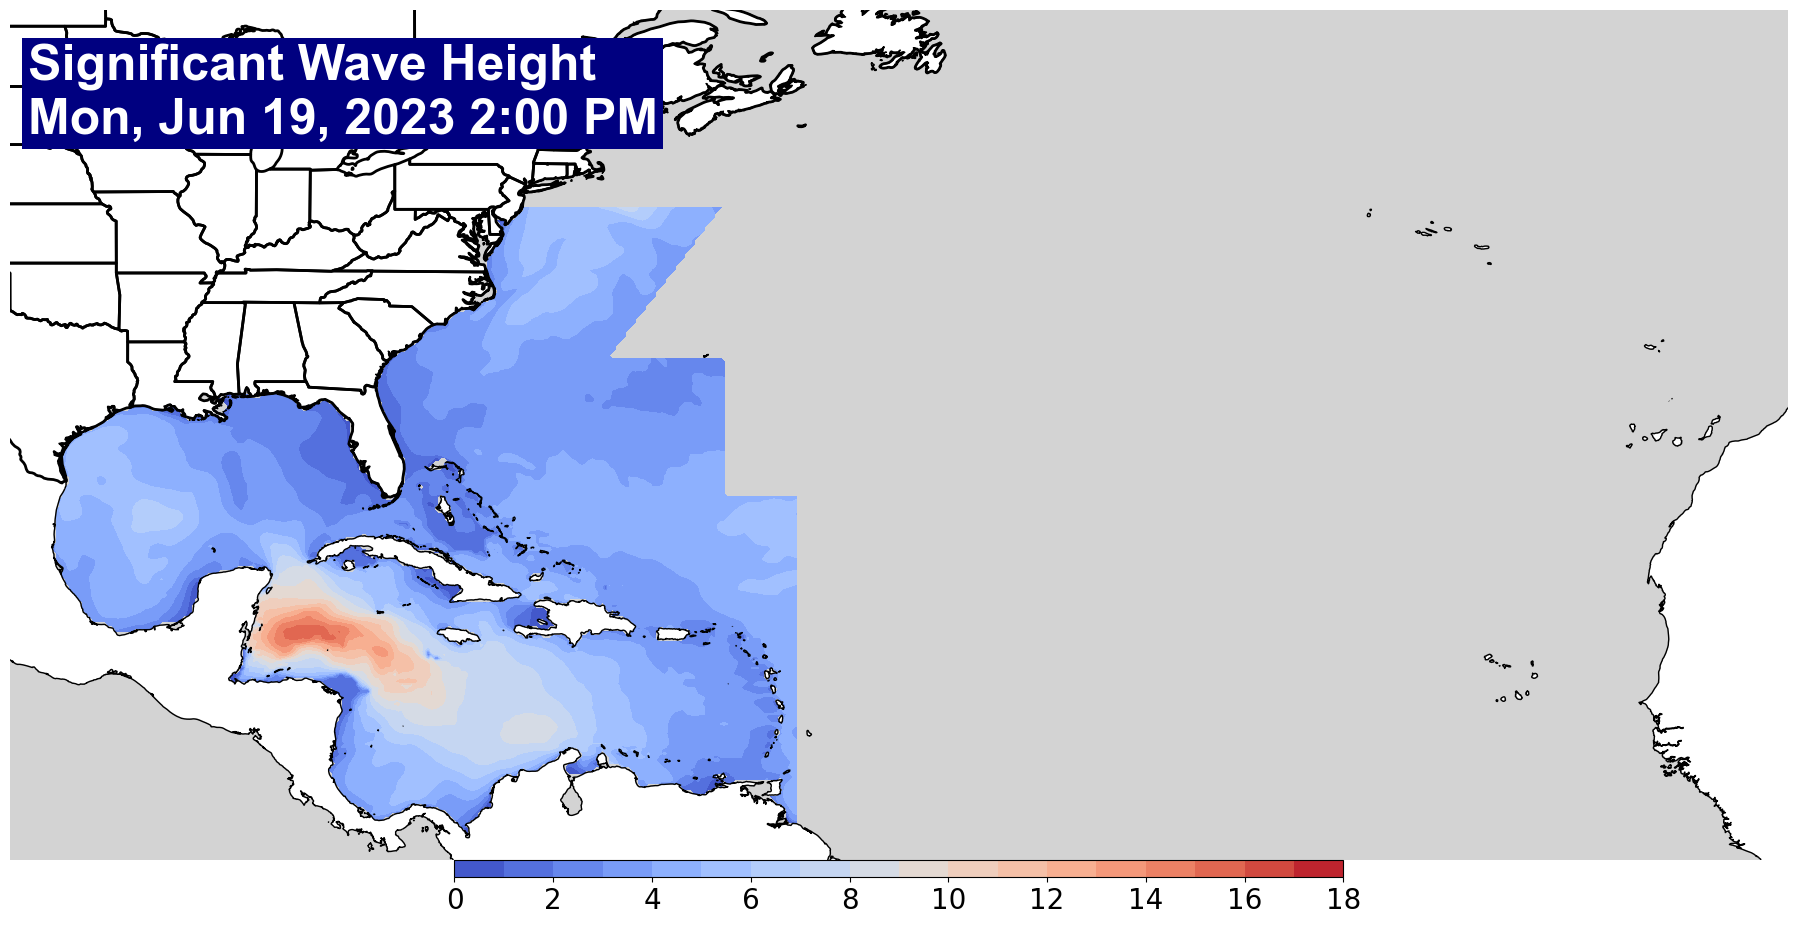

In [4]:
new_map = Map(LOCATION)
new_map.remove_international_states()
new_map.add_title(f'Significant Wave Height\n{LOCAL_TIME}')

fig, ax = new_map.make_map()

# Plot data
wave_contours = np.arange(0, 19, 1)
contour_fill = ax.contourf(lons, lats, period, wave_contours,
                           cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Plot colorbar
cbar = plt.colorbar(contour_fill, orientation='horizontal', pad=0, aspect=50, shrink=0.5,)
cbar.ax.tick_params(labelsize=20)

# Save figure
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
plt.savefig(f'{graphics_dir}/waveperiod_{VALID_TIME}.png', dpi=72)
plt.show()